![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+GenAI%2FChunking&file=Process+Documents+-+Document+AI+Layout+Parser.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520GenAI%2FChunking%2FProcess%2520Documents%2520-%2520Document%2520AI%2520Layout%2520Parser.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Chunking/Process%20Documents%20-%20Document%20AI%20Layout%20Parser.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Process Documents With The Document AI Layout Parser

This workflow creates chunks from documents to be used in embeddings workflow examples in [this series](./Embeddings/readme.md) as well as throughout the [Applied GenAI](../readme.md) series. This workflow will give examples for:
- This document:[Official Rules of Baseball](https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf)
- Processed and chunked using the [Layout Parser from Document AI](https://cloud.google.com/document-ai/docs/layout-parse-chunk)
- And results are stored in a local folder(`./layout-parser/document-chunks.jsonl`) in this repository

**Document AI** Workflow
<p align="center" width="100%"><center>
    <img src="../../architectures/architectures/images/working with/documentai/readme/high_level.png">
</center></p>

This workflow shows how to use the processor named **Layout Parser** to:
- Process Documents
    - Online request
    - Batch request
- Parse Responses
    - chunks
    - blocks
        - paragraphs
        - tables
        - titles
        - headings
        - page header
        - page footer

Learn more about Document AI and the wide variety of parsers as well as methods for working with the responses in this series: [Working With Document AI](../../Working%20With/Document%20AI/readme.md)

---
## Colab Setup

When running this notebook in [Colab](https://colab.google/) or [Colab Enterprise](https://cloud.google.com/colab/docs/introduction), this section will authenticate to GCP (follow prompts in the popup) and set the current project for the session.

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [22]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.documentai', 'google-cloud-documentai', '2.31.0'),
    ('google.cloud.storage', 'google-cloud-storage'),
    ('fitz', 'pymupdf'),
    ('PIL', 'Pillow')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [5]:
!gcloud services enable documentai.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [6]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

Inputs

In [7]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [53]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'layout-parser'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

Packages

In [54]:
import os
import re
import IPython.display
import io
import json
import base64
import requests
import concurrent.futures
import asyncio
import fitz #pymupdf
import PIL.Image

from google.cloud import documentai
from google.cloud import storage

Clients

In [224]:
# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)
docai_async_client = documentai.DocumentProcessorServiceAsyncClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

Parameters:

In [378]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [379]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Document

The [official rules of baseball](https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf), a pdf that is updated annually with the latest changes to the game and published by MLB.


### Load The Document

In [202]:
url = 'https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf'

In [203]:
response = requests.get(url).content
document = fitz.open(stream = response, filetype = "pdf")

In [204]:
document.page_count

192

### Get Text From Pages

In [264]:
pages = [page.get_text() for page in document]
pages[0]

'OFFICIAL BASEBALL RULES\n2023 Edition\n'

### View Pages

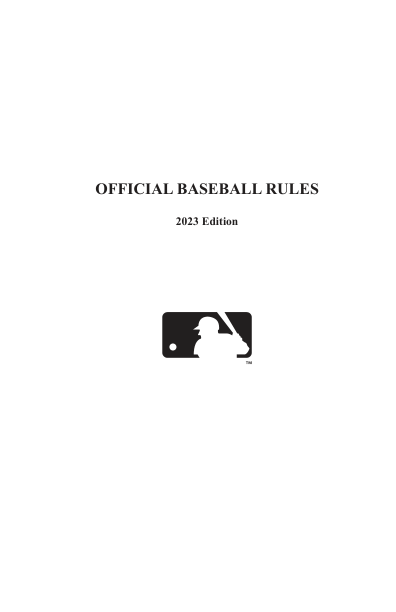

In [362]:
def get_image(page):
    pix = page.get_pixmap()
    image = PIL.Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return image
page_images = [get_image(page) for page in document]
    
page_images[0]

### Create New PDF with First 5 pages

In [380]:
small_document = fitz.open()
small_document.insert_pdf(document, from_page=0, to_page=4)

In [381]:
small_document.page_count

5

### Documents As Byte Strings

In [382]:
buffer = io.BytesIO()
document.save(buffer)
document_bytes = base64.b64encode(buffer.getvalue()).decode('utf-8')

buffer = io.BytesIO()
small_document.save(buffer)
small_document_bytes = base64.b64encode(buffer.getvalue()).decode('utf-8')

### Documents As Local Files

In [383]:
document.save(f"{DIR}/document.pdf")
small_document.save(f"{DIR}/small_document.pdf")

In [384]:
os.listdir(DIR)

['small_document.pdf', 'document.pdf']

### Documents As GCS Files

In [212]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files/document.pdf')
blob.upload_from_string(base64.b64decode(document_bytes), content_type = 'application/pdf')

In [213]:
blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files/small_document.pdf')
blob.upload_from_string(base64.b64decode(small_document_bytes), content_type = 'application/pdf')

In [214]:
list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files'))

[<Blob: statmike-mlops-349915, applied-genai/layout-parser/files/document.pdf, 1726672977725587>,
 <Blob: statmike-mlops-349915, applied-genai/layout-parser/files/small_document.pdf, 1726672977953232>]

---
## Layout Parser

Document AI is comprised of multiple processors.  In this case the [Layout Parser](https://cloud.google.com/document-ai/docs/layout-parse-chunk) is used for its ability to detect and extract paragraphs, tables, titles, heading, page headers, and page footers.  

For a more thorough review of Document AI processors, including customized parsers, see the [Working With/Document AI](../../Working%20With/Document%20AI/readme.md) section of this repository.  This repository includes examples of processing documents at larger scales and storing the data for processing and retrieval.

### Get/Create Processor: Layout Parser

In [48]:
PARSER_DISPLAY_NAME = 'my_layout_processor'
PARSER_TYPE = 'LAYOUT_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-layout-parser-v1.0-2024-06-03'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
    if p.display_name == PARSER_DISPLAY_NAME:
        parser = p
try:
    print('Retrieved existing parser: ', parser.name)
except Exception:
    parser = docai_client.create_processor(
        parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
        processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
    )
    print('Created New Parser: ', parser.name)

Retrieved existing parser:  projects/1026793852137/locations/us/processors/3779bd3a8f535977


---
## Process Document - Multiple Ways

The [Layout Parser](https://cloud.google.com/document-ai/docs/layout-parse-chunk) can process different files types:
- HTML
- PDF
- DOCX
- PPTX
- XLSX/XLSM

There are limitations for processing based on the online versus the batch clients:
- Online: 20MB per file and up to 15 pages
- Batch: 40MB per file and up to 500 pages, but multiple files (up to 5,000 per request)

The parsed content from this parser will contain:
- paragraphs
- tables
- titles
- headings
- page header
- page footer
- chunks

The clients have default [quotas](https://cloud.google.com/document-ai/quotas) and [limits](https://cloud.google.com/document-ai/limits):
- 1800 request per user per minute per project
    - online:
        - 600 per project
        - 120 per processor type
    - batch (concurrent):
        - 10 per project
        - 5 per processor
- see the links for more details


The code below shows multiple ways to process documents both online and batch:
- Online:
    - document inline (bytes)
    - Raw document (local folder)
    - GCS document (GCS)
- Online Async with multiple request of the same document, for different page ranges
- Batch: documents in GCS
    - Multiple document

### Online Processing: Inline Document

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - `inline_document` = [documentai.Document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)
    - `process_options` = [documentai.ProcessOptions()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions)
        - `layout_config` = [documentai.ProcessOptions.LayoutConfig()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.LayoutConfig)

In [171]:
online_inline_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = parser.name,
        inline_document = documentai.Document(
            content = small_document_bytes,
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        ),
    )
)

#### Review response for `document_layout.blocks`:

- The document is parsed into a block structure based on headings

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [172]:
online_inline_response.document.document_layout.blocks[0].text_block.text

'OFFICIAL BASEBALL RULES'

#### Review response for `chunked_document.chunks`:

- number of chunks and the first chunk

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [173]:
len(online_inline_response.document.chunked_document.chunks)

11

In [174]:
online_inline_response.document.chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 2
}

### Online Processing: Raw Document

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - `raw_document` = [documentai.RawDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.RawDocument)
    - `process_options` = [documentai.ProcessOptions()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions)
        - `layout_config` = [documentai.ProcessOptions.LayoutConfig()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.LayoutConfig)

In [175]:
online_raw_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = parser.name,
        raw_document = documentai.RawDocument(
            content = small_document_bytes,
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)

#### Review response for `document_layout.blocks`:

- The document is parsed into a block structure based on headings

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [176]:
online_raw_response.document.document_layout.blocks[0].text_block.text

'OFFICIAL BASEBALL RULES'

#### Review response for `chunked_document.chunks`:

- number of chunks and the first chunk

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [177]:
len(online_raw_response.document.chunked_document.chunks)

11

In [178]:
online_raw_response.document.chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 2
}

### Online Processing: GCS Document

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - `gcs_document` = [documentai.GcsDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.GcsDocument)
    - `process_options` = [documentai.ProcessOptions()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions)
        - `layout_config` = [documentai.ProcessOptions.LayoutConfig()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.LayoutConfig)

In [179]:
online_gcs_response = docai_client.process_document(
    request = documentai.ProcessRequest(
        name = parser.name,
        gcs_document = documentai.GcsDocument(
            gcs_uri = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files/small_document.pdf',
            mime_type = 'application/pdf'
        ),
        process_options = documentai.ProcessOptions(
            from_start = 5,
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)

#### Review response for `document_layout.blocks`:

- The document is parsed into a block structure based on headings

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [180]:
online_gcs_response.document.document_layout.blocks[0].text_block.text

'OFFICIAL BASEBALL RULES'

#### Review response for `chunked_document.chunks`:

- number of chunks and the first chunk

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [181]:
len(online_gcs_response.document.chunked_document.chunks)

11

In [182]:
online_gcs_response.document.chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 2
}

### Batch Processing: Multiple Documents and/or Larger Documents

With batch processing there are two ways to specify documents.  A list of documents with uris or a prefix for the uri to match.  Either of these would work for the `input_documents` parameter of batch processing here:

**List Each Document**
```
        input_documents = documentai.BatchDocumentsInputConfig(
            gcs_documents = documentai.GcsDocuments(
                documents = [
                    
                    documentai.GcsDocument(
                        gcs_uri = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files/document.pdf',
                        mime_type = 'application/pdf'
                    ),
                    documentai.GcsDocument(
                        gcs_uri = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files/small_document.pdf',
                        mime_type = 'application/pdf'
                    )
                ]
            )
        )
```
**Common Prefix For Documents**
```
        input_documents = documentai.BatchDocumentsInputConfig(
            gcs_prefix = documentai.GcsPrefix(
                gcs_uri_prefix = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files'
            )
        )
```

Reference:
- [google.cloud.documentai.DocumentProcessorServiceClient.batch_process_documents()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_batch_process_documents)

In [215]:
batch_job = docai_client.batch_process_documents(
    request = documentai.BatchProcessRequest(
        name = parser.name,
        input_documents = documentai.BatchDocumentsInputConfig(
            gcs_prefix = documentai.GcsPrefix(
                gcs_uri_prefix = f'gs://{bucket.name}/{SERIES}/{EXPERIMENT}/files/'
            )
        ),
        document_output_config = documentai.DocumentOutputConfig(
            gcs_output_config = documentai.DocumentOutputConfig.GcsOutputConfig(
                gcs_uri = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/parsing'
            )
        ),
        process_options = documentai.ProcessOptions(
            layout_config = documentai.ProcessOptions.LayoutConfig(
                chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size = 100,
                    include_ancestor_headings = True,
                )
            )
        )
    )
)

print(f'Waiting on batch job to complete: {batch_job.operation.name}')
batch_job.result()

print(documentai.BatchProcessMetadata(batch_job.metadata).state)

Waiting on batch job to complete: projects/1026793852137/locations/us/operations/4246794143789906350
State.SUCCEEDED


#### Retrieve Document Parsing Results

In [216]:
batch_responses = []
for process in documentai.BatchProcessMetadata(batch_job.metadata).individual_process_statuses:
    matches = re.match(r"gs://(.*?)/(.*)", process.output_gcs_destination)
    output_bucket, output_prefix = matches.groups()
    output_blobs = bucket.list_blobs(prefix = output_prefix)
    for blob in output_blobs:
        response = documentai.Document.from_json(blob.download_as_bytes(), ignore_unknown_fields = True)
        batch_responses.append((blob.name.split('/')[-1], response))

In [217]:
len(batch_responses)

2

#### Review response for a document:

The full contents of the response will be covered in the [Process Responses](#process-responses) section below.

In [218]:
batch_responses[0][0], batch_responses[1][0]

('document-0.json', 'small_document-0.json')

In [219]:
batch_responses[0][1].chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 7
}
page_footers {
  text: "V1"
  page_span {
    page_start: 6
    page_end: 6
  }
}
page_footers {
  text: "vii"
  page_span {
    page_start: 7
    page_end: 7
  }
}

In [220]:
batch_responses[1][1].chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 2
}

### Online Async Processing: Multiple Parallel Requests For Different Pages

The online request are limited in file size and number of pages.  In this case, the layout parser, the limit is 15 pages for online and 500 for batch. 

There are ways to work with document segments with the online client and this enables processing of larger content.  Additionally, the async client for Document AI makes it possible to handle multiple simoultaneous request from a single client session.

The example below shows using these techniques to process the entire 192 page document with online processing.

Reference:
- [documentai.ProcessRequest()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessRequest)
    - `inline_document` = [documentai.Document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)
    - `process_options` = [documentai.ProcessOptions()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions)
        - `individual_page_selector` = [documenai.ProcessOptions.IndividualPageSelector](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.IndividualPageSelector)
        - `layout_config` = [documentai.ProcessOptions.LayoutConfig()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessOptions.LayoutConfig)

#### Determine The Number of Document Segments

A single request for online processing can handle 15 pages.  Determine the number of 15 page segments with a little math:
- how many full 15 page segments: `document.page_count // 15`
- is there a partial segment at the end?: `1 * min(1, document.page_count % 15)`
- add these together

In [222]:
document.page_count

192

In [223]:
num_segments = document.page_count // 15 + 1 * min(1, document.page_count % 15)
num_segments

13

In [226]:
page_segments = []
for segment in range(num_segments):
    page_segments.append(
        [i+1 for i in range(15*segment, min(document.page_count, 15*(segment + 1)))]
    )

In [233]:
print(
    'Number of segments: ', len(page_segments),
    '\nPages in first segment: ', page_segments[0],
    '\nPages in last segment: ', page_segments[-1]
)

Number of segments:  13 
Pages in first segment:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] 
Pages in last segment:  [181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192]


#### Async Requests For Each Segment:

In [229]:
online_async_responses = await asyncio.gather(
    *[
        docai_async_client.process_document(
            request = documentai.ProcessRequest(
                name = parser.name,
                inline_document = documentai.Document(
                    content = document_bytes,
                    mime_type = 'application/pdf'
                ),
                process_options = documentai.ProcessOptions(
                    individual_page_selector = documentai.ProcessOptions.IndividualPageSelector(
                        pages = segment
                    ),
                    layout_config = documentai.ProcessOptions.LayoutConfig(
                        chunking_config = documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                            chunk_size = 100,
                            include_ancestor_headings = True,
                        )
                    )
                ),
            )
        ) for segment in page_segments
    ]
)

#### Review response for each segment:

How many chunks were created for each segment?

In [235]:
for response in online_async_responses:
    print(len(response.document.chunked_document.chunks))

867
867
867
867
867
867
867
867
867
867
867
867
867


**Note to check:** It appears the full document is being processe rather than the page range even though it exceed the 15 page max

---
## Process Responses

Each of the methods covered above process the document into parts.  This section will show how to extract information from, parse, the result.

### Review The Response Parts

Use the batch processing method above and get the response for the full document:


In [249]:
batch_responses[0][0]

'document-0.json'

The response is in the form of a [documentai.Document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

In [250]:
response = batch_responses[0][1]
type(response)

google.cloud.documentai_v1.types.document.Document

For this parser, the layout parser, there are two key object in the `documentai.Document()`:
- [documentai.Document.DocumentLayout()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.DocumentLayout)
- [documentai.Document.ChunkedDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.ChunkedDocument)

In [251]:
type(response.document_layout)

google.cloud.documentai_v1.types.document.Document.DocumentLayout

In [252]:
type(response.chunked_document)

google.cloud.documentai_v1.types.document.Document.ChunkedDocument

### Review The `Document.ChunkedDocument` Parts

The `document.chunked_document` contains a list of `chunks`.  These are made up of:
- `chunk_id` is an id for the individual chunk
- `content` is the text of the content in the chunk
- `page_span` the page span the chunk is from
    - `page_start` is the page where the chunk starts
    - `page_end` is the page where the chunk ends
- `page_footers` is a footer assoicated with the chunk
    - `text` is the footers text
    - `page_span` the page span the footer is from
        - `page_start` is the page where the footer starts
        - `page_end` is the page where the footer ends
- `page_headers` is a header associated with the chunk
    - `text` is the headers text
    - `page_span` the page span the header is from
        - `page_start` is the page where the header starts
        - `page_end` is the page where the header ends

Reference:
- [documentai.Document.ChunkedDocument()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.ChunkedDocument)

In [279]:
type(response.chunked_document)

google.cloud.documentai_v1.types.document.Document.ChunkedDocument

In [256]:
type(response.chunked_document.chunks[0])

google.cloud.documentai_v1.types.document.Document.ChunkedDocument.Chunk

How many chunks were created from the document:

In [274]:
len(response.chunked_document.chunks)

867

View the first chunk:

In [257]:
response.chunked_document.chunks[0]

chunk_id: "c1"
content: "# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM"
page_span {
  page_start: 1
  page_end: 7
}
page_footers {
  text: "V1"
  page_span {
    page_start: 6
    page_end: 6
  }
}
page_footers {
  text: "vii"
  page_span {
    page_start: 7
    page_end: 7
  }
}

### Examine A Chunk

- See the content of a chunk
- Extract each part of a chunk
- View the pages and compare to the chunk

In [275]:
response.chunked_document.chunks[1]

chunk_id: "c2"
content: "# OFFICIAL BASEBALL RULES\n\n## Official Baseball Rules 2023 Edition\n\n### JOINT COMPETITION COMMITTEE\n\n|-|-|-|\n| Bill DeWitt | Whit Merrifield | Austin Slater |\n| Jack Flaherty | Bill Miller | John Stanton, Chair |\n| Tyler Glasnow | Dick Monfort | Tom Werner |\n| Greg Johnson | Mark Shapiro |  |\n\nCommittee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball"
page_span {
  page_start: 2
  page_end: 3
}

In [276]:
response.chunked_document.chunks[1].chunk_id

'c2'

In [277]:
response.chunked_document.chunks[1].content

'# OFFICIAL BASEBALL RULES\n\n## Official Baseball Rules 2023 Edition\n\n### JOINT COMPETITION COMMITTEE\n\n|-|-|-|\n| Bill DeWitt | Whit Merrifield | Austin Slater |\n| Jack Flaherty | Bill Miller | John Stanton, Chair |\n| Tyler Glasnow | Dick Monfort | Tom Werner |\n| Greg Johnson | Mark Shapiro |  |\n\nCommittee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball'

In [278]:
print(response.chunked_document.chunks[1].content)

# OFFICIAL BASEBALL RULES

## Official Baseball Rules 2023 Edition

### JOINT COMPETITION COMMITTEE

|-|-|-|
| Bill DeWitt | Whit Merrifield | Austin Slater |
| Jack Flaherty | Bill Miller | John Stanton, Chair |
| Tyler Glasnow | Dick Monfort | Tom Werner |
| Greg Johnson | Mark Shapiro |  |

Committee Secretary Paul V. Mifsud, Jr. Copyright © 2023 by the Office of the Commissioner of Baseball


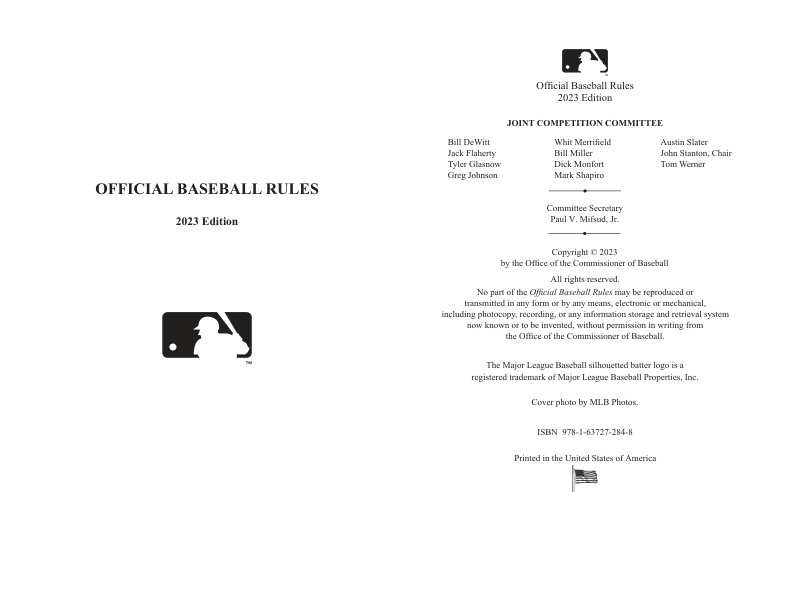

In [273]:
show = PIL.Image.new('RGB', (page_images[0].size[0]+page_images[1].size[0], page_images[0].size[1]))
show.paste(page_images[0], (0,0))
show.paste(page_images[1], (page_images[0].size[0], 0))
show

**Description**

Notice that the chunk include the heading hierarchy that the chunk falls under.  In this case that is three levels down: title > heading 1 > heading 2.  Reviewing the page images it is clear that page 1 has the title, page 2 is a subsection, and the "JOINT COMPETITION COMMITEE" is detetect as a third level.

Note that the committe members are presented side-by-side in three colums.  This is presented in the `content` of the chunk with markdown so that it retains the tabular information.

### Process and Store Chunks

This section shows how to:
- convert chunks to a Python dictionary
- store the chunks in a JSONL file in this repository

> Note: The `documentai.document.Document` object is a protobuf.  It has built-in methods for conversion of messages like `.to_dict()` and `.to_json()`.  These follow the `google.protobuf.json_format` - [reference](https://googleapis.dev/python/protobuf/latest/google/protobuf/json_format.html).  That means the parameters of `.to_dict()` are the same as `google.protobuf.json_format.MessageToDict()` which includes `use_integer_for_enums` which should be set `= False` to get the text representation of enum values.

Convert document object to Python dictionary and get a list of dictionaries for each chunk:

In [291]:
chunks = documentai.Document.to_dict(response, use_integers_for_enums = False)['chunked_document']['chunks']

In [292]:
type(chunks[0])

dict

In [293]:
chunks[0]

{'chunk_id': 'c1',
 'content': '# OFFICIAL BASEBALL RULES\n\n2023 Edition TM TM',
 'page_span': {'page_start': 1, 'page_end': 7},
 'page_footers': [{'text': 'V1',
   'page_span': {'page_start': 6, 'page_end': 6}},
  {'text': 'vii', 'page_span': {'page_start': 7, 'page_end': 7}}],
 'source_block_ids': [],
 'page_headers': []}

In [385]:
len(chunks)

867

Create A local file of JSONL from the list of chunk dictionaries:

In [386]:
with open(f'{DIR}/document-chunks.jsonl', 'w') as f:
    for chunk in chunks:
        f.write(json.dumps(chunk)+ '\n')

In [387]:
os.listdir(DIR)

['document-chunks.jsonl', 'small_document.pdf', 'document.pdf']

### Review The `Document.DocumentLayout` Parts

The `document.document_layout` contains a list of `blocks`.  These are made up of:
- `block_id` is the id for the individual block
- one of:
    - `text_block` is a block of text content
        - `text` the text from the block
        - `type_` is the type of text: paragraph, subtitle, heading-1, heading-2, heading-3, heading-4, heading-5, header, footer
        - `blocks` is a list of nested blocks
    - `table_block` is a block of tabular content
        - `header_rows` is a list of header rows for the table
            - `cells` is a list of cells for the row
                - `blocks` is a list of content blocks for the cell
                - `row_span` is how many rows this cell spans
                - `col_span` is how many columns this cell spans
        - `body_rows` is a list of content rows for the table
            - `cells` is a list of cells for the row
                - `blocks` is a list of content blocks for the cell
                - `row_span` is how many rows this cell spans
                - `col_span` is how many columns this cell spans
        - `caption` is the text of a caption or title
    - `list_block` is a block with a list
        - `list_entries` is a list of entry blocks
            - `blocks` is a list of content blocks for the list entry
        - `type_` is the type of list: ordered, unordered
- `page_span` the page span the block is from
    - `page_start` is the page where the block starts
    - `page_end` is the page where the block ends

Reference:
- [documentai.Document.DocumentLayout()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document.DocumentLayout)

In [299]:
type(response.document_layout)

google.cloud.documentai_v1.types.document.Document.DocumentLayout

In [300]:
type(response.document_layout.blocks[0])

google.cloud.documentai_v1.types.document.Document.DocumentLayout.DocumentLayoutBlock

How many chunks were created from the document:

In [301]:
len(response.document_layout.blocks)

133

View the first block:

In [303]:
#response.document_layout.blocks[0]

In [305]:
response.document_layout.blocks[0].block_id

'1'

In [306]:
response.document_layout.blocks[0].page_span

page_start: 1
page_end: 7

In [308]:
response.document_layout.blocks[0].text_block.text

'OFFICIAL BASEBALL RULES'

In [310]:
response.document_layout.blocks[0].text_block.type_

'heading-1'

In [311]:
len(response.document_layout.blocks[0].text_block.blocks)

7

### Examine Blocks

A block can be very large because it can span multiple pages and be multiple levels deep as it represents headings.  The following routine will count the levels of each elment type for each block and present a summary:

Convert document object to Python dictionary and get a list of dictionaries for each chunk:

In [312]:
blocks = documentai.Document.to_dict(response, use_integers_for_enums = False)['document_layout']['blocks']

In [313]:
type(blocks[0])

dict

In [315]:
len(blocks)

133

Blocks are structured representations of sections of the document that the parser detected based on heading levels and titles.  

In [356]:
blocks[0]['page_span']

{'page_start': 1, 'page_end': 7}

In [357]:
blocks[1]['page_span']

{'page_start': 7, 'page_end': 13}

In [358]:
blocks[2]['page_span']

{'page_start': 13, 'page_end': 13}

In [359]:
blocks[3]['page_span']

{'page_start': 13, 'page_end': 14}

In [361]:
blocks[-2]['page_span']

{'page_start': 187, 'page_end': 187}

In [360]:
blocks[-1]['page_span']

{'page_start': 187, 'page_end': 187}

The last page appears to have multiple blocks.  Here is a view of that page:

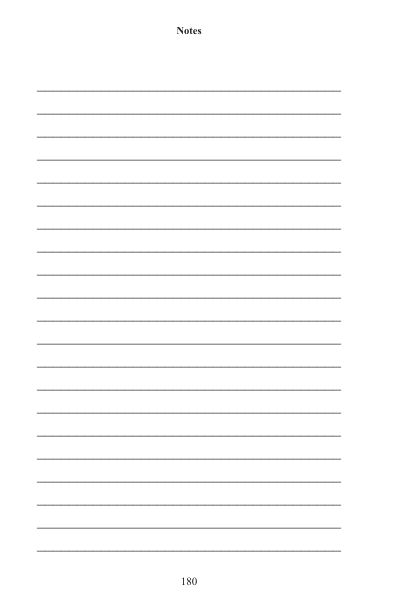

In [364]:
page_images[-1]

Sumarize a block:
This function will summarize a block and print out the details:

In [365]:
def summarize_blocks(blocks):
    """Provides a descriptive summary of a list of dictionaries with nested block structures.

    Args:
        blocks: A list of dictionaries representing content blocks.

    Returns:
        A string with a summary of the block structure.
    """
    summary = ""
    for block in blocks:
        for key, value in block.items():
            if key == "text_block":
                text_type = value.get('type_', 'unknown type')
                summary += f"- Text block ({text_type}): {value.get('text', '')[:50]}...\n"
                if value.get("blocks"):
                    summary += "  Nested blocks:\n"
                    summary += summarize_blocks(value["blocks"])  # Recursive call
            elif key == "table_block":
                summary += "- Table block\n"
                if value.get("header_rows"):
                    summary += f"  Header rows: {len(value['header_rows'])}\n"
                if value.get("body_rows"):
                    summary += f"  Body rows: {len(value['body_rows'])}\n"
                if value.get("caption"):
                    summary += f"  Caption: {value['caption']}\n"
            elif key == "list_block":
                summary += "- List block\n"
                if value.get("list_entries"):
                    summary += f"  List entries: {len(value['list_entries'])}\n"

    return summary

# Example usage with your provided data
summary = summarize_blocks(blocks[0:1])
print(summary)

- Text block (heading-1): OFFICIAL BASEBALL RULES...
  Nested blocks:
- Text block (paragraph): 2023 Edition...
- Text block (paragraph): TM...
- Text block (paragraph): TM...
- Text block (heading-2): Official Baseball Rules 2023 Edition...
  Nested blocks:
- Text block (heading-3): JOINT COMPETITION COMMITTEE...
  Nested blocks:
- Table block
  Body rows: 4
- Text block (paragraph): Committee Secretary...
- Text block (paragraph): Paul V. Mifsud, Jr....
- Text block (paragraph): Copyright © 2023...
- Text block (paragraph): by the Office of the Commissioner of Baseball...
- Text block (heading-3): All rights reserved....
  Nested blocks:
- Text block (paragraph): No part of the Official Baseball Rules may be repr...
- Text block (paragraph): The Major League Baseball silhouetted batter logo ...
- Text block (paragraph): Cover photo by MLB Photos....
- Text block (paragraph): ISBN 978-1-63727-284-8...
- Text block (paragraph): Printed in the United States of America...
- Text block (h

### Process and Store Blocks

This section shows how to:
- store the blocks in a JSONL file in this repository

In [374]:
type(blocks[0])

dict

In [375]:
len(blocks)

133

Create A local file of JSONL from the list of chunk dictionaries:

In [388]:
with open(f'{DIR}/document-blocks.jsonl', 'w') as f:
    for block in blocks:
        f.write(json.dumps(block)+ '\n')

In [389]:
os.listdir(DIR)

['document-chunks.jsonl',
 'small_document.pdf',
 'document.pdf',
 'document-blocks.jsonl']